In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [15]:
basic_model_path = '/home/student/Data-analysis-and-presentation/HW2/hw2_094295/models/basic_model.pt'
basic_model = models.resnet50(pretrained=False)
# Fit the last layer for our specific task
num_ftrs = basic_model.fc.in_features
basic_model.fc = nn.Linear(num_ftrs, 10)
basic_model.load_state_dict(torch.load(basic_model_path))
basic_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [65]:
base_dir = os.path.join("..", "data")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

BATCH_SIZE = 16

def imshow(inp, title=None):
    """Imshow for Tensors."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(3, 3))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


def load_datasets(train_dir, val_dir):
    """Loads and transforms the datasets."""
    # Resize the samples and transform them into tensors
    data_transforms = transforms.Compose([transforms.Resize([64, 64]), transforms.ToTensor()])

    # Create a pytorch dataset from a directory of images
    train_dataset = datasets.ImageFolder(train_dir, data_transforms)
    val_dataset = datasets.ImageFolder(val_dir, data_transforms)

    return train_dataset, val_dataset


train_dataset, val_dataset = load_datasets(train_dir, val_dir)

class_names = train_dataset.classes
print("The classes are: ", class_names)

# Dataloaders initialization
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# for i in range(3):
#     inputs, classes = next(iter(train_dataloader))
#     out = torchvision.utils.make_grid(inputs)
#     imshow(out, title=[class_names[x] for x in classes])


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

The classes are:  ['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


In [67]:
incorrect_dict = dict()
predictions_list = list()
labels_list = list()
index = 0
for inputs, labels in tqdm(train_dataset):

    inputs = torch.unsqueeze(inputs, dim=0)
    outputs = basic_model(inputs)
    _, preds = torch.max(outputs, 1)
    
    labels_list.append(labels)
    predictions_list.append(preds.item())
    #add incorrect indices to dict to be accessed later
    if labels != preds.item():
        incorrect_dict[index] = dict()
        incorrect_dict[index]['inputs'] = torch.squeeze(inputs)
        incorrect_dict[index]['labels'] = labels
        incorrect_dict[index]['preds'] = preds.item()
        incorrect_dict[index]['outputs'] = outputs
    index += 1
# all_labels = labels_list
# all_predictions = np.hstack(predictions_list)

100%|██████████| 2067/2067 [00:36<00:00, 56.24it/s]


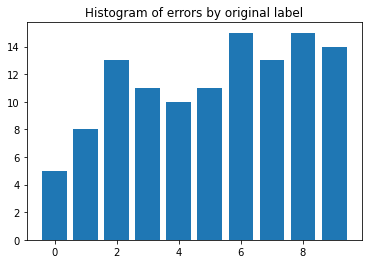

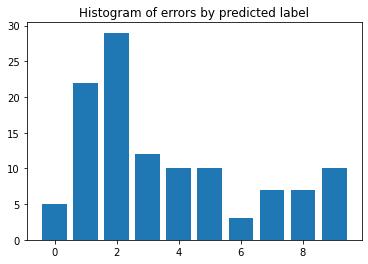

In [95]:
# create historgram of errors based on original label
original_label_amount = [0] * 10
predicted_label_amount = [0] * 10
for index, details in incorrect_dict.items():
    original_label_amount[details['labels']] += 1
    predicted_label_amount[details['preds']] += 1

plt.bar(x=list(range(10)), height=original_label_amount)
plt.title("Histogram of errors by original label")
plt.show()
plt.bar(x=list(range(10)), height=predicted_label_amount)
plt.title("Histogram of errors by predicted label")
plt.show()

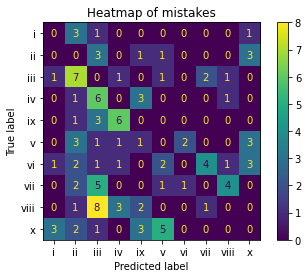

In [86]:
cm = confusion_matrix(labels_list, predictions_list, labels=list(range(10)))
np.fill_diagonal(cm, 0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names)
disp.plot()
plt.title("Heatmap of mistakes")
plt.show()

In [70]:
print(f"Total of {len(incorrect_dict.keys())} wrong in train by basic model")

Total of 115 wrong in train by basic model


For predicted 1

450
Labeled: 2 | Predicted: 0


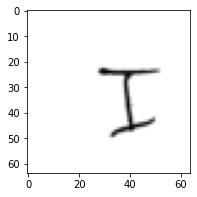

1338
Labeled: 6 | Predicted: 0


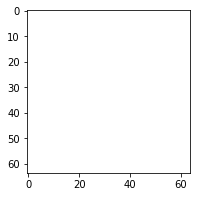

2013
Labeled: 9 | Predicted: 0


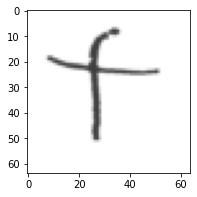

2027
Labeled: 9 | Predicted: 0


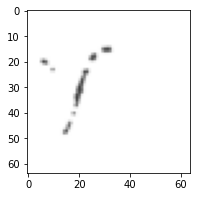

2037
Labeled: 9 | Predicted: 0


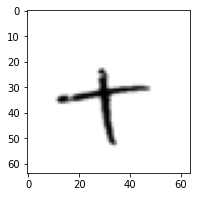

In [88]:
for i, (index, details) in enumerate(incorrect_dict.items()):
    if details['preds'] != 0:
        continue
    else:
        print(index)
        print(f"Labeled: {details['labels']} | Predicted: {details['preds']}")
        imshow(train_dataset[index][0])

For predicted 2

7
Labeled: 0 | Predicted: 1


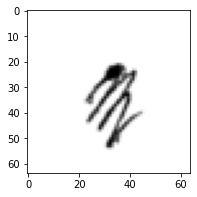

162
Labeled: 0 | Predicted: 1


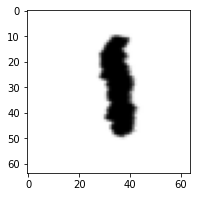

168
Labeled: 0 | Predicted: 1


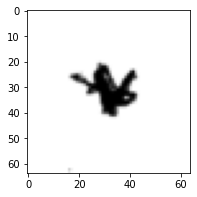

444
Labeled: 2 | Predicted: 1


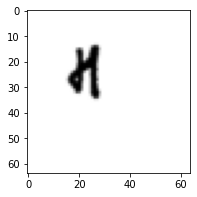

477
Labeled: 2 | Predicted: 1


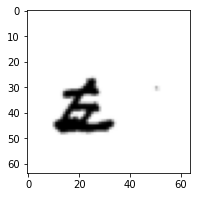

489
Labeled: 2 | Predicted: 1


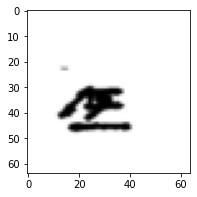

530
Labeled: 2 | Predicted: 1


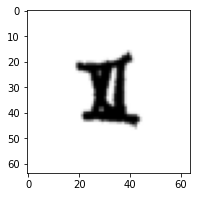

535
Labeled: 2 | Predicted: 1


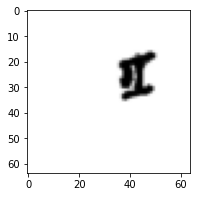

579
Labeled: 2 | Predicted: 1


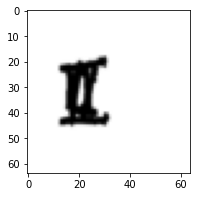

602
Labeled: 2 | Predicted: 1


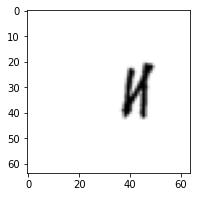

614
Labeled: 3 | Predicted: 1


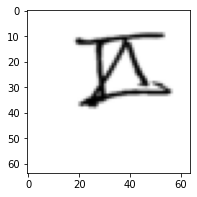

1118
Labeled: 4 | Predicted: 1


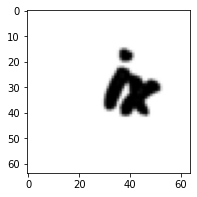

1162
Labeled: 5 | Predicted: 1


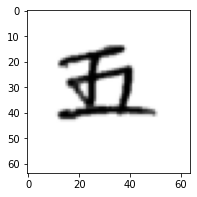

1262
Labeled: 5 | Predicted: 1


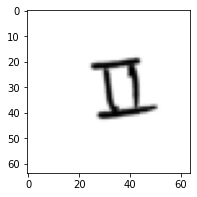

1279
Labeled: 5 | Predicted: 1


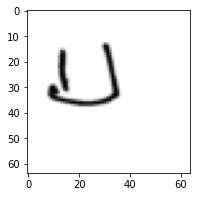

1352
Labeled: 6 | Predicted: 1


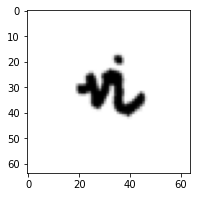

1377
Labeled: 6 | Predicted: 1


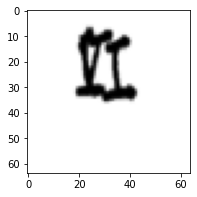

1590
Labeled: 7 | Predicted: 1


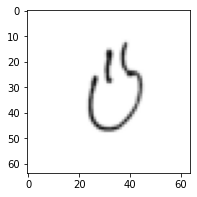

1643
Labeled: 7 | Predicted: 1


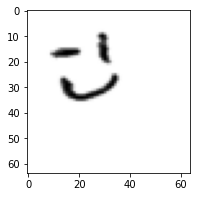

1877
Labeled: 8 | Predicted: 1


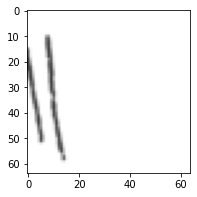

1965
Labeled: 9 | Predicted: 1


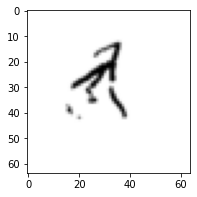

2045
Labeled: 9 | Predicted: 1


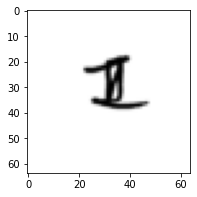

In [89]:
for i, (index, details) in enumerate(incorrect_dict.items()):
    if details['preds'] != 1:
        continue
    else:
        print(index)
        print(f"Labeled: {details['labels']} | Predicted: {details['preds']}")
        imshow(train_dataset[index][0])

In [34]:
print(all_labels)
print(all_predictions)

[9 4 4 0 8 2 9 7 2 0 0 4 2 4 7 9]
[9 4 4 0 8 2 9 7 2 0 0 4 2 4 5 4]


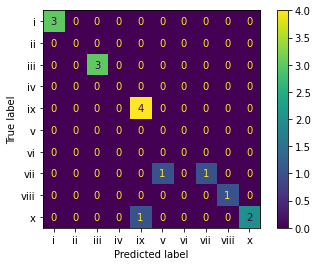

In [36]:
cm = confusion_matrix(all_labels, all_predictions, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names)
disp.plot()
plt.show()